In [0]:
#@title
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/trained_model"

# Car Model Make Year Classifier

In [0]:
import os
import math
import time
import numpy as np
import pandas as pd
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback

In [0]:
tf.__version__

'1.13.1'

In [0]:
'''
-----------------------------------
 Essential functions declared here
-----------------------------------
'''
def crop_image(from_dir, to_dir, data_frame, verbose=True):
  start_time = time.time()
  if not os.path.exists(to_dir):
    os.mkdir(to_dir)
  for label_count,car_label in enumerate(os.listdir(from_dir)):
    label_dir = from_dir +'/'+ car_label
    image_count = 0
    #create new car label dir
    new_car_label_dir = to_dir+'/'+car_label
    if not os.path.exists(new_car_label_dir):
      os.mkdir(new_car_label_dir)
    for image_count, car_image in enumerate(os.listdir(label_dir)):
      row = data_frame.loc[car_image]
      image_path = label_dir +'/'+ car_image
      image = Image.open(image_path)
      shape = image.size
      #crop and resize image
      bbox = (row.bboxx, row.bboyy, row.bboxwidth, row.bboxheight)
      x1 = max(bbox[0]-16, 0)
      y1 = max(bbox[1] - 16, 0)
      x2 = min(bbox[2] + 16, shape[0])
      y2 = min(bbox[3] + 16, shape[1])
      new_box = (x1, y1, x2, y2)
      image = image.crop(box = new_box)
      #save image to new destination
      image.save(new_car_label_dir+'/'+car_image, "JPEG", quality=100, optimize=True, progressive=True)
      if verbose:
        print(label_count+1," ",car_label,":",image_count+1, end='\r')
    if verbose:
      print("")
  print("--- %s seconds ---" % (time.time() - start_time))

def plot_image(feature_batch, labels):
    #show sample images from dataset
    total = 5
    col = 5
    figsize = (15,15)
    row = int(np.ceil(total / np.float(col)))
    fig = plt.figure(figsize=figsize)
    for index in range(total):
        ax = fig.add_subplot(row, col, index+1)
        ax.title.set_text(labels[index])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        plt.imshow(feature_batch[index].astype(int))
    return plt
  
def build_model(base_model, class_no, dr1=0.8, dr2=0.2):
  x = base_model.output # extract bottlenecks from pretrained convolutional network
  x = layers.GlobalAveragePooling2D()(x) # add pooling layer
  x = layers.Dropout(rate=dr1)(x) # add regularize layer
  x = layers.Dense(512, activation='relu')(x) # add fully connected layer with 512 nodes & Relu activation
  x = layers.Dropout(rate=dr2)(x)
  predictions = layers.Dense(class_no, activation='softmax')(x) # prediction outputs in last layer with softmax activation
  model = Model(inputs=base_model.input, outputs=predictions) # connect all the layers above and return as a model
  return model 

def model_eval(test_generator, model):
  start_time = time.time()
  steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
  predict_list = []
  ground_truth_list = []
  for step in range(steps):
      test_batch_x, test_batch_y = test_generator.next()
      #store all predicted result
      predict = load_model.predict_on_batch(test_batch_x)
      predict_class = np.argmax(predict, 1)
      for element in predict_class: predict_list.append(element)
      #store all ground_truth values
      ground_truth = np.argmax(test_batch_y, 1)
      for element in ground_truth: ground_truth_list.append(element)
  print("--- %s seconds ---" % (time.time() - start_time))
  return ground_truth_list, predict_list

'''
--------------------------------------------------------------------------------
Custom learning decay function
learning rate is initially set to 0.0001 and dropped linearly at every 5 epochs
--------------------------------------------------------------------------------
'''
def step_decay(epoch):
    initial_lrate = 0.00005 #stage2 first training
    #initial_lrate = 0.000025 #stage2 second training
    drop = 0.5
    epochs_drop = 8.0
    lrate = initial_lrate * math.pow(drop,  
         math.floor((epoch)/epochs_drop))
    return lrate

'''
----------------------------------------------------
Print current learning rate at the end of each epoch
----------------------------------------------------
'''
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def plot_confusion_matrix(predict_y, ground_truth_label, class_names):
  cm = confusion_matrix(y_true=ground_truth_label, y_pred=predict_y)
  df_cm = pd.DataFrame(
      cm, index=class_names, columns=class_names, 
  )
  fig = plt.figure(figsize=(25,25))
  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return cm

## Download Cars dataset
Note that download command can only run on Linux-based environment / Google Colab

In [0]:
!pip install kaggle

In [0]:
'''Linux command'''
# upload and move kaggle API json to specific directory
# Kaggle API is required to download the dataset from Kaggle
!mkdir -p ../root/.kaggle
!mv ../kaggle.json /root/.kaggle/kaggle.json

In [0]:
'''Linux command'''
# download Cars dataset from Kaggle
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder -p dataset/kaggle/ --unzip
# unzip car_data
! unzip -u -q dataset/kaggle/car_data -d dataset/kaggle/
!ls dataset/kaggle/car_data

## Load Car Dataset

In [0]:
datapath = 'dataset/kaggle'

In [0]:
# read csv
heading = ['filename','bboxx','bboyy','bboxwidth','bboxheight','classNo']
df_train = pd.read_csv(datapath+'/anno_train.csv',names=heading).assign(test=0).set_index('filename') # load train set
df_test = pd.read_csv(datapath+'/anno_test.csv',names=heading).assign(test=1).set_index('filename') # load test set
df_train.head()

,bboxx,bboyy,bboxwidth,bboxheight,classNo,test
filename,,,,,,
00001.jpg,39,116,569,375,14,0
00002.jpg,36,116,868,587,3,0
00003.jpg,85,109,601,381,91,0
00004.jpg,621,393,1484,1096,134,0
00005.jpg,14,36,133,99,106,0


In [0]:
# load dataset labels
labels = pd.read_csv(datapath+'/names.csv',names=['ClassName'])
labels.head()

,ClassName
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [0]:
# modify data frame index
df_test=df_test.assign(ClassName=df_test.classNo.map(labels.ClassName))
df_train=df_train.assign(ClassName=df_train.classNo.map(labels.ClassName))
df_test.head()

,bboxx,bboyy,bboxwidth,bboxheight,classNo,test,ClassName
filename,,,,,,,
00001.jpg,30,52,246,147,181,1,Suzuki Kizashi Sedan 2012
00002.jpg,100,19,576,203,103,1,Ferrari 458 Italia Coupe 2012
00003.jpg,51,105,968,659,145,1,Jeep Wrangler SUV 2012
00004.jpg,67,84,581,407,187,1,Toyota Corolla Sedan 2012
00005.jpg,140,151,593,339,185,1,Toyota Sequoia SUV 2012


## Preprocess Images
Car dataset split to 50-50 for train and test set. Then, the images are preprocessed by cropping them based on the boundary box provided with an additional 16 pixels on it. Preprocessed images are then saved in new dataset directory. Note that only training set is cropped out, testing set will be left as it.

In [0]:
train_dir = 'dataset/kaggle/car_data/train'
test_dir = 'dataset/kaggle/car_data/test'
new_train_dir = 'dataset/kaggle/car_data/cropped_train'

In [0]:
#preprocess train dataset
crop_image(train_dir, new_train_dir, df_train, verbose=False)

--- 337.29676389694214 seconds ---


## Plot Cars' Distribution

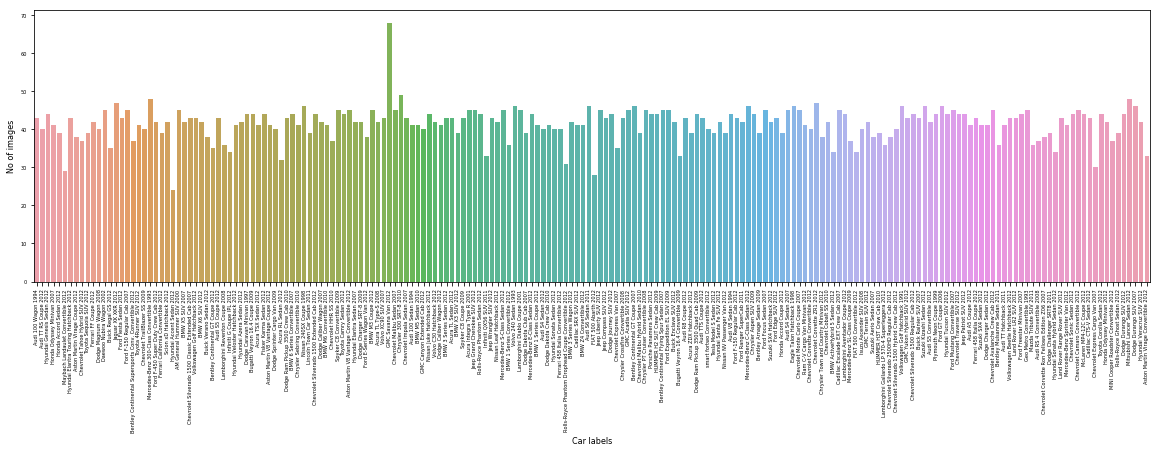

In [0]:
car_dir_list = os.listdir(new_train_dir)
label_counts = {}
for car_dir in car_dir_list:
    images = os.listdir(new_train_dir+"/"+car_dir)
    label_counts[car_dir] = len(images)
labels = [k for k in label_counts.keys()]
counts = [v for v in label_counts.values()]

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=5)
sns.barplot(x=labels, y=counts, alpha = 0.9)
plt.xticks(rotation = 90)
plt.xlabel('Car labels', fontsize = 8)
plt.ylabel('No of images', fontsize = 8)
plt.show()

## Build Classification Model

In [0]:
input_width = 299
input_height = 299
input_depth = 3
BATCH_SIZE = 16

###Import Pretrained Model
We will be using Transfer Learning technique to train our model. Inception-ResnetV2 is chose as the base model. It is loaded with the weights that are previously trained on the Imagenet dataset. The base model is fine-tuned to reach its best performance. Note that only training set is cropped, testing set will be left as is.

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# load pretrained model weights
base_model = InceptionResNetV2(weights='imagenet', input_shape=(input_width, input_height, input_depth), include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 7s 0us/step


## Load dataset as Generator

In [0]:
#augment the training dataset to prevent overfit
train_datagen = ImageDataGenerator(rotation_range=40,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   fill_mode="nearest",
                                   preprocessing_function=preprocess_input)

# Create train generator
train_generator = train_datagen.flow_from_directory(new_train_dir,
                                                    target_size=(input_width, input_height),
                                                    batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create test generator
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(input_width, input_height), 
                                                  shuffle=False, 
                                                  batch_size=100)
print("Labels:", train_generator.class_indices)

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
Labels: {'AM General Hummer SUV 2000': 0, 'Acura Integra Type R 2001': 1, 'Acura RL Sedan 2012': 2, 'Acura TL Sedan 2012': 3, 'Acura TL Type-S 2008': 4, 'Acura TSX Sedan 2012': 5, 'Acura ZDX Hatchback 2012': 6, 'Aston Martin V8 Vantage Convertible 2012': 7, 'Aston Martin V8 Vantage Coupe 2012': 8, 'Aston Martin Virage Convertible 2012': 9, 'Aston Martin Virage Coupe 2012': 10, 'Audi 100 Sedan 1994': 11, 'Audi 100 Wagon 1994': 12, 'Audi A5 Coupe 2012': 13, 'Audi R8 Coupe 2012': 14, 'Audi RS 4 Convertible 2008': 15, 'Audi S4 Sedan 2007': 16, 'Audi S4 Sedan 2012': 17, 'Audi S5 Convertible 2012': 18, 'Audi S5 Coupe 2012': 19, 'Audi S6 Sedan 2011': 20, 'Audi TT Hatchback 2011': 21, 'Audi TT RS Coupe 2012': 22, 'Audi TTS Coupe 2012': 23, 'Audi V8 Sedan 1994': 24, 'BMW 1 Series Convertible 2012': 25, 'BMW 1 Series Coupe 2012': 26, 'BMW 3 Series Sedan 2012': 27, 'BMW 3 Series Wagon 2012': 28, 'BMW 6 Series 

Found 8144 images belonging to 196 classes.


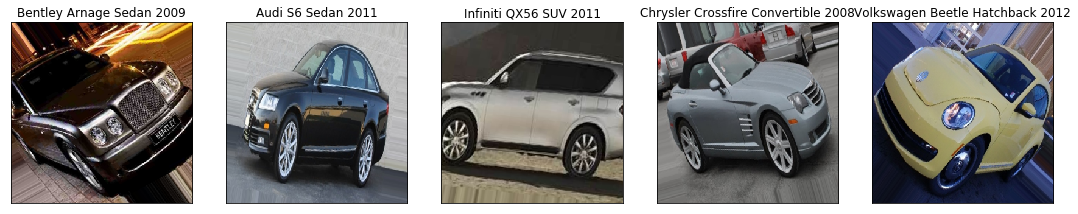

In [0]:
# plot some sample images
visualize_gen = ImageDataGenerator(rotation_range=40,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   fill_mode="nearest")
visualize_train_generator = visualize_gen.flow_from_directory(new_train_dir,
                                                    target_size=(input_width, input_height), 
                                                    batch_size=64)
feature_batch, y_label = visualize_train_generator.next()
retrieved_labels = []
for index in np.argmax(y_label, axis=1): 
  retrieved_labels.append([label for label in visualize_train_generator.class_indices.keys()][index])
plot_image(feature_batch, retrieved_labels).show()

## Training: Stage 1
Start Training with last 10 unfrozen layers

In [0]:
# define total class no
class_no = len(train_generator.class_indices)
# build model
model = build_model(base_model=base_model, class_no=class_no)

In [0]:
# unfreeze last 10 layers for training
model.trainable = True
for layer in model.layers[:-10]:
  layer.trainable = False
print('trainable parameters:', len(model.trainable_variables))

trainable parameters: 8


In [0]:
# implement early stopping callback with tolerance of 10 epochs that has no improvement on validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
# learning rate in first stage is set 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [0]:
# model summary include: model architecture, total model parameters etc.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
# start training
history = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator,
                              epochs=100,
                              verbose=2,
                              callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
81/81 [==============================] - 104s 1s/step - loss: 5.1823 - acc: 0.0250
 - 357s - loss: 5.4144 - acc: 0.0071 - val_loss: 5.1823 - val_acc: 0.0250
Epoch 2/100
81/81 [==============================] - 92s 1s/step - loss: 5.0086 - acc: 0.0432
 - 335s - loss: 5.2210 - acc: 0.0145 - val_loss: 5.0086 - val_acc: 0.0432
Epoch 3/100
81/81 [==============================] - 92s 1s/step - loss: 4.6924 - acc: 0.0521
 - 336s - loss: 5.0835 - acc: 0.0249 - val_loss: 4.6924 - val_acc: 0.0521
Epoch 4/100
81/81 [==============================] - 92s 1s/step - loss: 4.3522 - acc: 0.0665
 - 335s - loss: 4.8673 - acc: 0.0371 - val_loss: 4.3522 - val_acc: 0.0665
Epoch 5/100
81/81 [==============================] - 92s 1s/step - loss: 4.1207 - acc: 0.0783
 - 334s - loss: 4.6341 - acc: 0.0533 - val_loss: 4.1207 - val_acc: 0.0783
Epoch 6/100
81/81 [==============================] - 92s 1s/step - loss: 3.8897 - acc: 0.0997
 - 335s - loss: 4

### Plot Training Graph

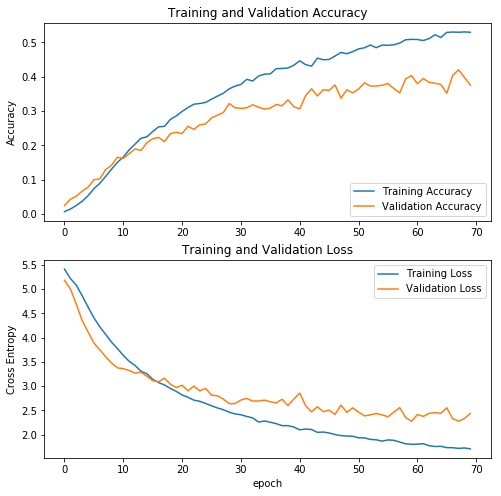

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

np.savetxt('acc.txt', acc)
np.savetxt('val-acc.txt', val_acc)
np.savetxt('loss.txt', loss)
np.savetxt('val-loss.txt', val_loss)

In [0]:
# save trained model
model.save('stage1_model.h5')
model.save_weights('stage1_model_weights.h5')

## Training: Stage 2
The model is loaded from stage1 training and we unfreeze all the layers to allow fully trainning on the model.

In [0]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# load pretrained model weights
base_model = InceptionResNetV2(weights='imagenet', input_shape=(input_width, input_height, input_depth), include_top=False)
# unfreeze all layers
base_model.trainable=True

In [0]:
class_no = len(train_generator.class_indices)
#dropout rate is increased to prevent fully tuned model from overfitting
load_model = build_model(base_model=base_model, class_no=class_no)

In [0]:
# model is loaded from stage1 training
load_model.load_weights('stage1_model_weights.h5')
# load_model.load_weights('drive/My Drive/trained_model/stage2_model_weights.h5')

In [0]:
load_model.trainable = True
print("trainable variables:", len(load_model.trainable_variables))

trainable variables: 492


In [0]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

load_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0), metrics=['accuracy'])

In [0]:
load_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_203 (Bat (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_v1_203[0][0] 
__________________________________________________________________________________________________
conv2d_204

In [0]:
history = load_model.fit_generator(generator=train_generator,
                                   validation_data=test_generator,
                                   epochs=100,
                                   verbose=2,
                                   callbacks=[es, lrate, loss_history])

Epoch 1/100
81/81 [==============================] - 98s 1s/step - loss: 1.1086 - acc: 0.6972
lr: 5e-05
 - 487s - loss: 1.4356 - acc: 0.5974 - val_loss: 1.1086 - val_acc: 0.6972
Epoch 2/100
81/81 [==============================] - 94s 1s/step - loss: 0.9925 - acc: 0.7211
lr: 5e-05
 - 462s - loss: 1.0354 - acc: 0.6917 - val_loss: 0.9925 - val_acc: 0.7211
Epoch 3/100
81/81 [==============================] - 94s 1s/step - loss: 0.8671 - acc: 0.7621
lr: 5e-05
 - 462s - loss: 0.8158 - acc: 0.7531 - val_loss: 0.8671 - val_acc: 0.7621
Epoch 4/100
81/81 [==============================] - 93s 1s/step - loss: 0.8323 - acc: 0.7709
lr: 5e-05
 - 461s - loss: 0.6734 - acc: 0.7932 - val_loss: 0.8323 - val_acc: 0.7709
Epoch 5/100
81/81 [==============================] - 93s 1s/step - loss: 0.8933 - acc: 0.7574
lr: 5e-05
 - 461s - loss: 0.5576 - acc: 0.8247 - val_loss: 0.8933 - val_acc: 0.7574
Epoch 6/100
81/81 [==============================] - 93s 1s/step - loss: 0.8302 - acc: 0.7637
lr: 5e-05
 - 461

In [0]:
load_model.save('stage2_model.h5')
load_model.save_weights('stage2_model_weights.h5')

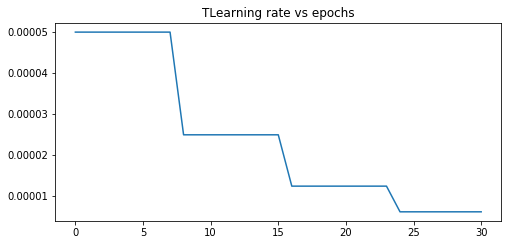

In [0]:
lr_history = history.history['lr']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['lr'])
plt.title('TLearning rate vs epochs')
plt.show()
np.savetxt('lr-history.txt', lr_history)

###Plot Training Graph

In [0]:
# load training history from stage 1 training
acc = [num for num in np.loadtxt('acc.txt')]
val_acc = [num for num in np.loadtxt('val-acc.txt')]
loss = [num for num in np.loadtxt('loss.txt')]
val_loss = [num for num in np.loadtxt('val-loss.txt')]

In [0]:
# append stage1 training history with stage2 training history
acc += history.history['acc']
val_acc += history.history['val_acc']

loss += history.history['loss']
val_loss += history.history['val_loss']

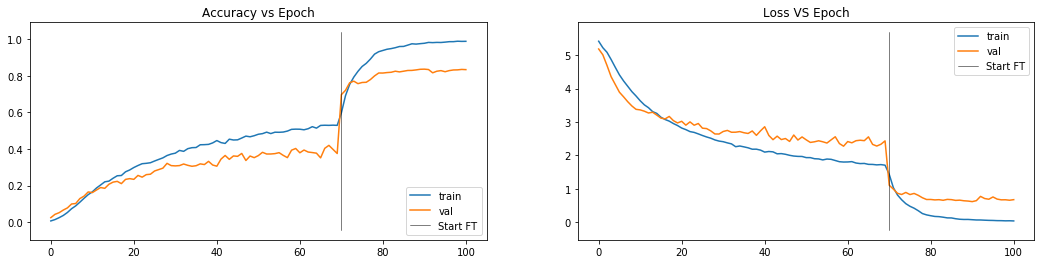

In [0]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.plot([70,70], plt.ylim(), 'k-', label='Start FT', linewidth=0.5)
plt.legend(loc='lower right')
plt.title('Accuracy vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.plot([70,70], plt.ylim(), 'k-', label='Start FT', linewidth=0.5)
plt.legend(loc='upper right')
plt.title('Loss VS Epoch')
plt.show()

In [0]:
np.savetxt('acc.txt', acc)
np.savetxt('val-acc.txt', val_acc)
np.savetxt('loss.txt', loss)
np.savetxt('val-loss.txt', val_loss)

##Evaluate on Test Set: Loss and Accuracy

In [0]:
_loss, _acc = load_model.evaluate_generator(test_generator)
print("loss: %.3f" % _loss)
print("accuracy: %.2f%%" % (_acc * 100))

loss: 0.677
accuracy: 83.40%


##Evaluate on Test Set: Precision, Recall and F1

In [0]:
ground_truth_list, predict_list = model_eval(test_generator, load_model)

--- 141.58842134475708 seconds ---


In [0]:
print('Recall:%.2f%%' % (precision_score(ground_truth_list, predict_list, average='micro') * 100))
print('Precision:%.2f%%' % (recall_score(ground_truth_list, predict_list, average='micro') * 100))
print('F1 score:%.2f%%'% (f1_score(ground_truth_list, predict_list, average='micro') * 100))

Recall:83.40%
Precision:83.40%
F1 score:83.40%


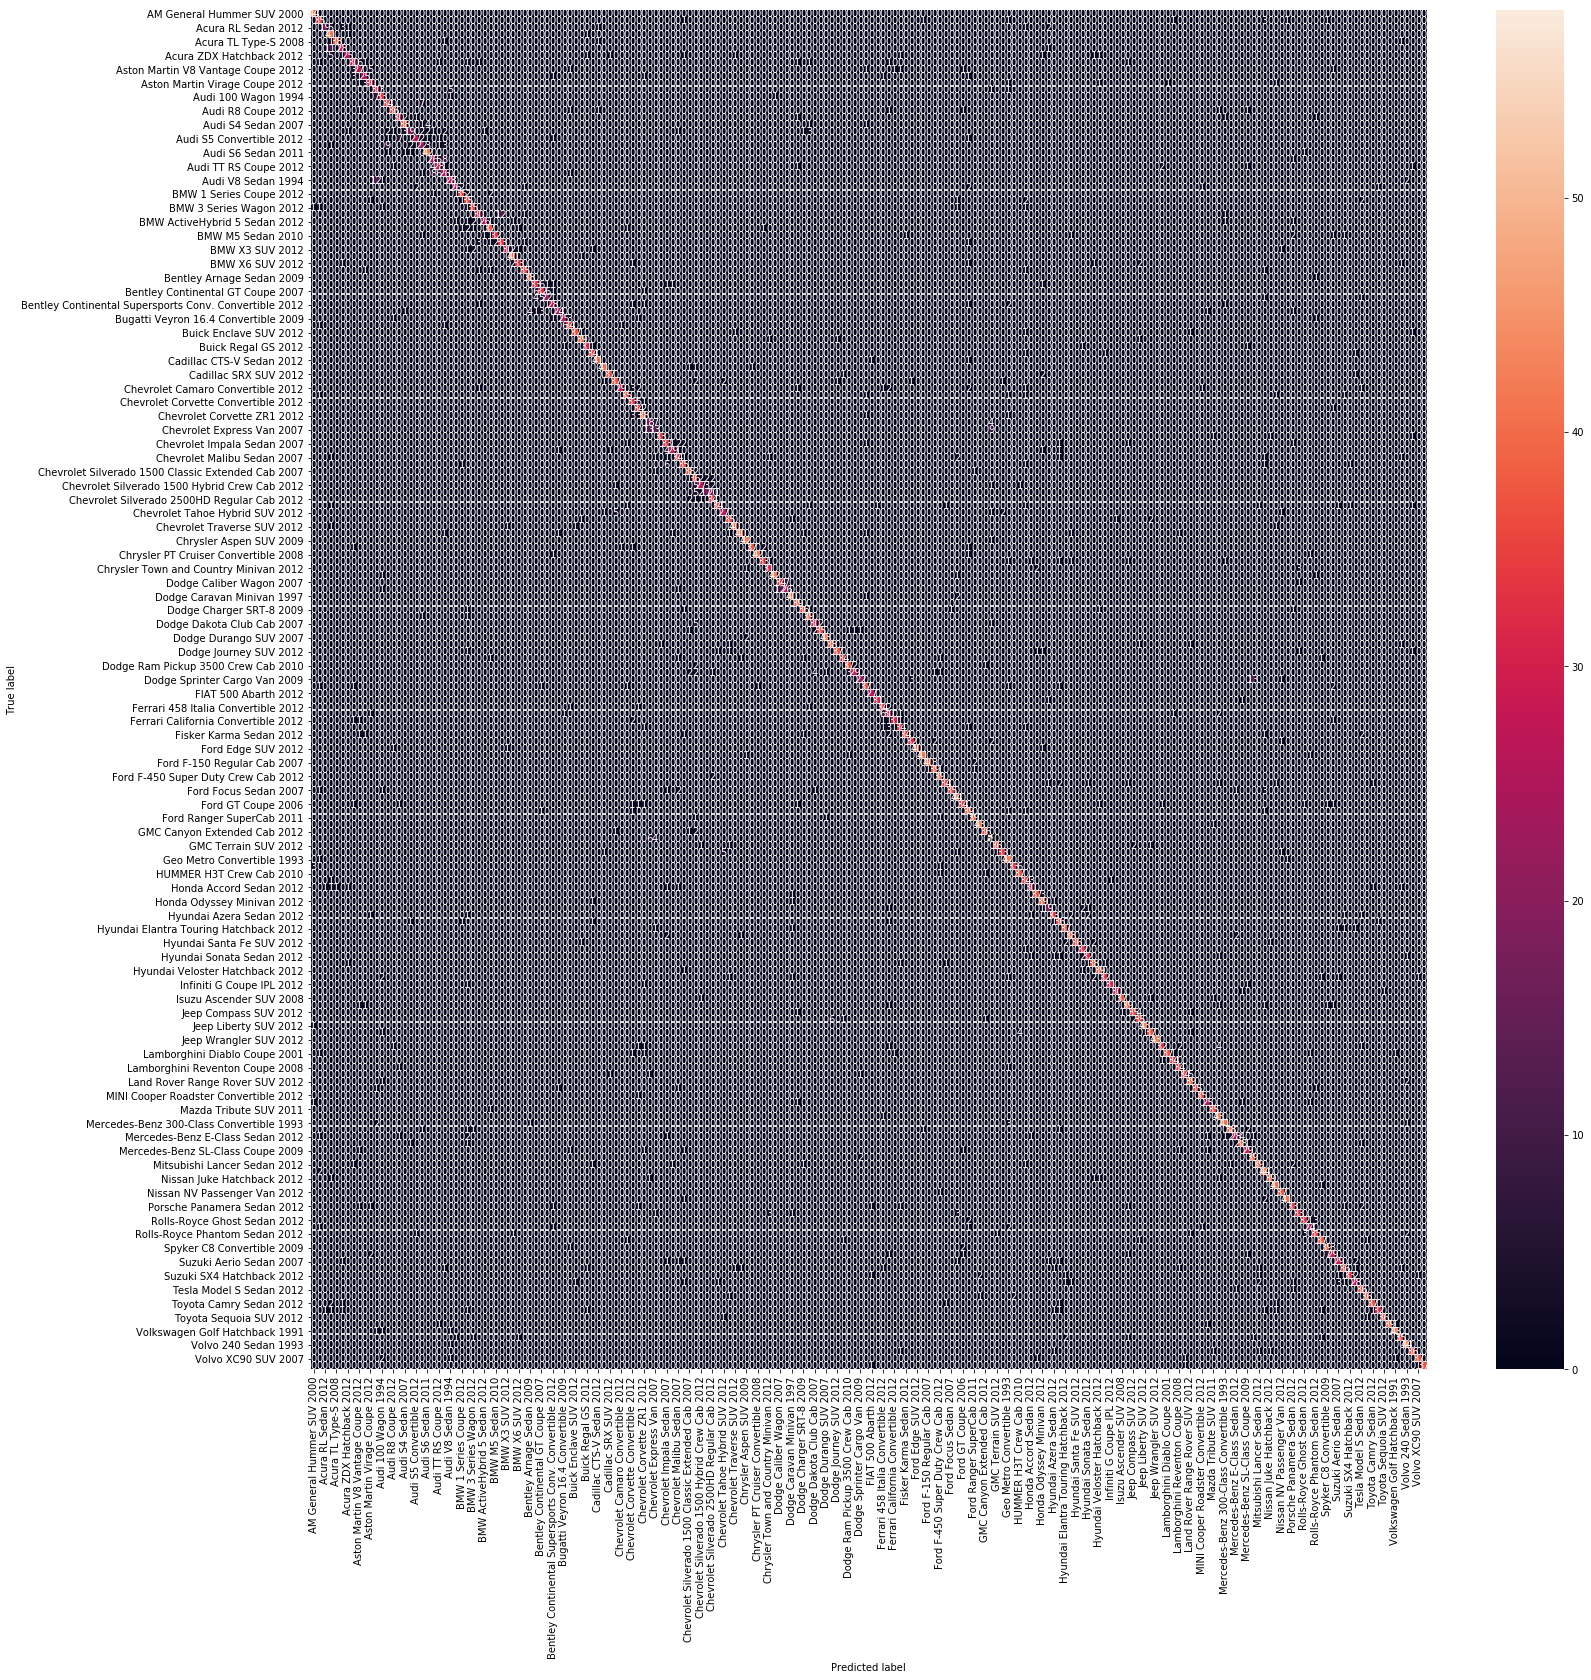

In [0]:
cm = plot_confusion_matrix(predict_list, ground_truth_list, test_generator.class_indices.keys())